In [22]:
# working model with basic features from application_train and previous applications
# Added actual and expected EAR from previous applications

In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.feature_selection import VarianceThreshold
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc
warnings.filterwarnings('ignore')

In [24]:
print('Importing data...')
train = pd.read_csv('application_train.csv')
test = pd.read_csv('application_test.csv')
previous_ear = pd.read_csv('actual_expected_ear.csv')

Importing data...


In [25]:
previous_ear.head(5)

,SK_ID_CURR,MEAN_ACTUAL_EAR,MEDIAN_ACTUAL_EAR,STD_ACTUAL_EAR,MEAN_EXPECTED_EAR,MEDIAN_EXPECTED_EAR,STD_EXPECTED_EAR
0,100001,0.272618,0.272618,0.00000,1.199400,1.199400,0.000000
1,100002,0.256557,0.256557,0.00000,0.238453,0.238453,0.000000
2,100003,0.398378,0.401412,0.10681,0.368710,0.385640,0.083249
3,100004,0.405439,0.405439,0.00000,0.360515,0.360515,0.000000
4,100005,-1.000000,-1.000000,0.00000,0.516463,0.516463,0.730389


# <a id=1 > 1. Processing test and train dataset </a>

In [26]:
target = train['TARGET']
del train['TARGET']

In [27]:
data = pd.concat([train,test])

In [28]:
data.shape, train.shape, test.shape

((356255, 121), (307511, 121), (48744, 121))

In [29]:
docs = [col for col in data.columns if 'FLAG_DOC' in col]
# Flag_document features - count and kurtosis
data['DOCUMENT_COUNT'] = data[docs].sum(axis=1)
data['NEW_DOC_KURT'] = data[docs].kurtosis(axis=1)  #long tails

In [30]:
def get_age_label(days_birth):
    """ Return the age group label (int). """
    age_years = -days_birth / 365
    if age_years < 27: return 1
    elif age_years < 40: return 2
    elif age_years < 50: return 3
    elif age_years < 65: return 4
    elif age_years < 99: return 5
    else: return 0

In [31]:
# Categorical age - based on target=1 plot
data['AGE_RANGE'] = data['DAYS_BIRTH'].apply(lambda x: get_age_label(x))

In [32]:
# New features based on External sources
data['EXT_SOURCES_PROD'] = data['EXT_SOURCE_1'] * data['EXT_SOURCE_2'] * data['EXT_SOURCE_3']
data['EXT_SOURCES_WEIGHTED'] = data.EXT_SOURCE_1 * 2 + data.EXT_SOURCE_2 * 1 + data.EXT_SOURCE_3 * 3
np.warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encountered')
for function_name in ['min', 'max', 'mean', 'nanmedian', 'var']:
        feature_name = 'EXT_SOURCES_{}'.format(function_name.upper())
        data[feature_name] = eval('np.{}'.format(function_name))(
            data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']], axis=1)

In [33]:
# Credit ratios
data['CREDIT_TO_ANNUITY_RATIO'] = data['AMT_CREDIT'] / data['AMT_ANNUITY']
data['CREDIT_TO_GOODS_RATIO'] = data['AMT_CREDIT'] / data['AMT_GOODS_PRICE']

In [34]:
# Income ratios
data['ANNUITY_TO_INCOME_RATIO'] = data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
data['CREDIT_TO_INCOME_RATIO'] = data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']
data['INCOME_TO_EMPLOYED_RATIO'] = data['AMT_INCOME_TOTAL'] / data['DAYS_EMPLOYED']
data['INCOME_TO_BIRTH_RATIO'] = data['AMT_INCOME_TOTAL'] / data['DAYS_BIRTH']
data['INCOME_TO_CREDIT_RATION'] = data['AMT_INCOME_TOTAL'] / data['AMT_CREDIT']
data['INCOME_PER_PERSON'] = data['AMT_INCOME_TOTAL'] / data['CNT_FAM_MEMBERS']

In [35]:
# Time ratios
data['EMPLOYED_TO_BIRTH_RATIO'] = data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']
data['ID_TO_BIRTH_RATIO'] = data['DAYS_ID_PUBLISH'] / data['DAYS_BIRTH']
data['CAR_TO_BIRTH_RATIO'] = data['OWN_CAR_AGE'] / data['DAYS_BIRTH']
data['CAR_TO_EMPLOYED_RATIO'] = data['OWN_CAR_AGE'] / data['DAYS_EMPLOYED']
data['PHONE_TO_BIRTH_RATIO'] = data['DAYS_LAST_PHONE_CHANGE'] / data['DAYS_BIRTH']

In [36]:
# Join data with expected EAR
data = data.merge(previous_ear, on='SK_ID_CURR', how='left')

In [37]:
data.head(5)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,ID_TO_BIRTH_RATIO,CAR_TO_BIRTH_RATIO,CAR_TO_EMPLOYED_RATIO,PHONE_TO_BIRTH_RATIO,MEAN_ACTUAL_EAR,MEDIAN_ACTUAL_EAR,STD_ACTUAL_EAR,MEAN_EXPECTED_EAR,MEDIAN_EXPECTED_EAR,STD_EXPECTED_EAR
0,100002,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0.224078,NaN,NaN,0.119860,0.256557,0.256557,0.000000,0.238453,0.238453,0.000000
1,100003,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0.017358,NaN,NaN,0.049389,0.398378,0.401412,0.106810,0.368710,0.385640,0.083249
2,100004,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0.132889,-0.001365,-0.115556,0.042791,0.405439,0.405439,0.000000,0.360515,0.360515,0.000000
3,100006,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0.128229,NaN,NaN,0.032465,0.578911,0.199462,1.798905,0.282858,0.342949,0.294920
4,100007,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0.173490,NaN,NaN,0.055489,0.212948,0.641118,0.893287,0.690733,0.618032,0.232068


In [38]:
# differences in expected and Actual EAR
data['DIFFERENCE_MEAN_EAR'] = data['MEAN_EXPECTED_EAR'] - data['MEAN_ACTUAL_EAR']
data['DIFFERENCE_MEDIAN_EAR'] = data['MEAN_EXPECTED_EAR'] - data['MEDIAN_ACTUAL_EAR']

In [40]:
data.head(6)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CAR_TO_EMPLOYED_RATIO,PHONE_TO_BIRTH_RATIO,MEAN_ACTUAL_EAR,MEDIAN_ACTUAL_EAR,STD_ACTUAL_EAR,MEAN_EXPECTED_EAR,MEDIAN_EXPECTED_EAR,STD_EXPECTED_EAR,DIFFERENCE_MEAN_EAR,DIFFERENCE_MEDIAN_EAR
0,100002,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,NaN,0.119860,0.256557,0.256557,0.000000,0.238453,0.238453,0.000000,-0.018103,-0.018103
1,100003,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,0.049389,0.398378,0.401412,0.106810,0.368710,0.385640,0.083249,-0.029668,-0.032702
2,100004,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,-0.115556,0.042791,0.405439,0.405439,0.000000,0.360515,0.360515,0.000000,-0.044924,-0.044924
3,100006,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,NaN,0.032465,0.578911,0.199462,1.798905,0.282858,0.342949,0.294920,-0.296053,0.083397
4,100007,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,NaN,0.055489,0.212948,0.641118,0.893287,0.690733,0.618032,0.232068,0.477785,0.049615
5,100008,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,454500.0,...,NaN,0.149696,0.608476,0.397923,0.522351,0.365353,0.262448,0.342714,-0.243123,-0.032571


In [41]:
def do_mean(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].mean().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df


def do_median(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].median().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df


def do_std(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].std().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df


def do_sum(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].sum().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df

In [42]:
# Groupby: Statistics for applications in the same group
group = ['ORGANIZATION_TYPE', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 'AGE_RANGE', 'CODE_GENDER']
data = do_median(data, group, 'EXT_SOURCES_MEAN', 'GROUP_EXT_SOURCES_MEDIAN')
data = do_std(data, group, 'EXT_SOURCES_MEAN', 'GROUP_EXT_SOURCES_STD')
data = do_mean(data, group, 'AMT_INCOME_TOTAL', 'GROUP_INCOME_MEAN')
data = do_std(data, group, 'AMT_INCOME_TOTAL', 'GROUP_INCOME_STD')
data = do_mean(data, group, 'CREDIT_TO_ANNUITY_RATIO', 'GROUP_CREDIT_TO_ANNUITY_MEAN')
data = do_std(data, group, 'CREDIT_TO_ANNUITY_RATIO', 'GROUP_CREDIT_TO_ANNUITY_STD')
data = do_mean(data, group, 'AMT_CREDIT', 'GROUP_CREDIT_MEAN')
data = do_mean(data, group, 'AMT_ANNUITY', 'GROUP_ANNUITY_MEAN')
data = do_std(data, group, 'AMT_ANNUITY', 'GROUP_ANNUITY_STD')
data = do_mean(data, group, 'MEAN_EXPECTED_EAR', 'GROUP_MEAN_EXPECTED_EAR')
data = do_median(data, group, 'MEDIAN_EXPECTED_EAR', 'GROUP_MEDIAN_EXPECTED_EAR')
data = do_mean(data, group, 'STD_EXPECTED_EAR', 'GROUP_STD_EXPECTED_EAR')
data = do_mean(data, group, 'MEAN_ACTUAL_EAR', 'GROUP_MEAN_ACTUAL_EAR')
data = do_median(data, group, 'MEDIAN_ACTUAL_EAR', 'GROUP_MEDIAN_ACTUAL_EAR')
data = do_mean(data, group, 'STD_ACTUAL_EAR', 'GROUP_STD_ACTUAL_EAR')

In [43]:
data.head(6)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,GROUP_CREDIT_TO_ANNUITY_STD,GROUP_CREDIT_MEAN,GROUP_ANNUITY_MEAN,GROUP_ANNUITY_STD,GROUP_MEAN_EXPECTED_EAR,GROUP_MEDIAN_EXPECTED_EAR,GROUP_STD_EXPECTED_EAR,GROUP_MEAN_ACTUAL_EAR,GROUP_MEDIAN_ACTUAL_EAR,GROUP_STD_ACTUAL_EAR
0,100002,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,6.189382,423946.077897,24847.926485,12190.206798,0.485687,0.425466,0.255542,1.731396,0.381520,2.998243
1,100003,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,8.206111,717295.519651,29831.965939,15037.721692,0.419197,0.344274,0.241606,3.447678,0.352478,5.889898
2,100004,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,7.567490,627030.309524,27408.857143,13448.587113,0.414061,0.346106,0.256650,0.970870,0.419042,1.413925
3,100006,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,7.737152,602336.162211,26623.157514,12942.189239,0.398109,0.342894,0.255653,0.788642,0.341441,1.321883
4,100007,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,8.789658,904500.000000,28931.625000,10551.123924,0.468061,0.441016,0.227216,0.217052,0.470301,0.808600
5,100008,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,454500.0,...,7.575709,603509.384348,28091.903478,13009.232136,0.476706,0.414426,0.274849,0.996204,0.434492,1.737987


In [44]:
# one-hot encoding
categorical_features = [col for col in data.columns if data[col].dtype == 'object']
data = pd.get_dummies(data, columns=categorical_features)

In [45]:
data.shape

(356255, 291)

In [46]:
#Pre-processing previous_application
print('Pre-processing previous_application...')
prev = pd.read_csv('previous_application.csv')
prev_cat_features = [pcol for pcol in prev.columns if prev[pcol].dtype == 'object']
prev = pd.get_dummies(prev, columns=prev_cat_features)
avg_prev = prev.groupby('SK_ID_CURR').mean()
cnt_prev = prev[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
avg_prev['COUNT_PREV_APP'] = cnt_prev['SK_ID_PREV']
del avg_prev['SK_ID_PREV']

Pre-processing previous_application...


In [47]:
data = data.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR')

In [48]:
data.shape

(356255, 454)

In [49]:
train = data.iloc[:train.shape[0],:]
test = data.iloc[train.shape[0]:,]

In [50]:
data.shape, train.shape, test.shape

((356255, 454), (307511, 454), (48744, 454))

In [51]:
del train['SK_ID_CURR']
del test['SK_ID_CURR']

In [52]:
train_x, valid_x, train_y, valid_y = train_test_split(train, target, test_size=0.2, shuffle=True)

In [53]:
#------------------------Build LightGBM Model-----------------------
train_data=lgb.Dataset(train_x,label=train_y)
valid_data=lgb.Dataset(valid_x,label=valid_y)

In [54]:
#Select Hyper-Parameters
params = {'boosting_type': 'gbdt',
          'max_depth' : 10,
          'objective': 'binary',
          'nthread': 5,
          'num_leaves': 64,
          'learning_rate': 0.05,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 5,
          'reg_lambda': 10,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'auc'
          }

In [55]:
#Train model on selected parameters and number of iterations
lgbm = lgb.train(params,
                 train_data,
                 2500,
                 valid_sets=valid_data,
                 early_stopping_rounds= 40,
                 verbose_eval= 10
                 )

Training until validation scores don't improve for 40 rounds.
[10]	valid_0's auc: 0.744222
[20]	valid_0's auc: 0.749591
[30]	valid_0's auc: 0.755077
[40]	valid_0's auc: 0.758953
[50]	valid_0's auc: 0.762347
[60]	valid_0's auc: 0.765494
[70]	valid_0's auc: 0.768052
[80]	valid_0's auc: 0.770002
[90]	valid_0's auc: 0.771591
[100]	valid_0's auc: 0.772709
[110]	valid_0's auc: 0.773534
[120]	valid_0's auc: 0.774403
[130]	valid_0's auc: 0.775062
[140]	valid_0's auc: 0.775659
[150]	valid_0's auc: 0.776333
[160]	valid_0's auc: 0.776694
[170]	valid_0's auc: 0.776957
[180]	valid_0's auc: 0.777192
[190]	valid_0's auc: 0.777655
[200]	valid_0's auc: 0.777917
[210]	valid_0's auc: 0.778187
[220]	valid_0's auc: 0.778356
[230]	valid_0's auc: 0.778648
[240]	valid_0's auc: 0.778844
[250]	valid_0's auc: 0.779115
[260]	valid_0's auc: 0.779427
[270]	valid_0's auc: 0.77947
[280]	valid_0's auc: 0.779639
[290]	valid_0's auc: 0.779781
[300]	valid_0's auc: 0.779913
[310]	valid_0's auc: 0.779892
[320]	valid_0's au

In [56]:
# Confusion matrix
predictions_validy = lgbm.predict(valid_x)
p_validy = np.where(predictions_validy > 0.5, 1, 0)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(valid_y, p_validy)
cm

array([[56428,   146],
       [ 4765,   164]])

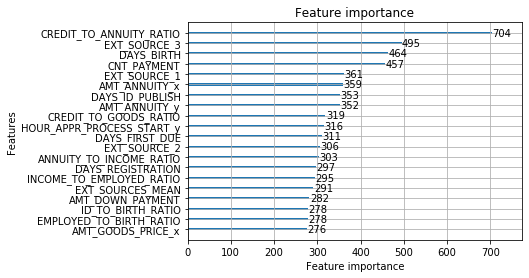

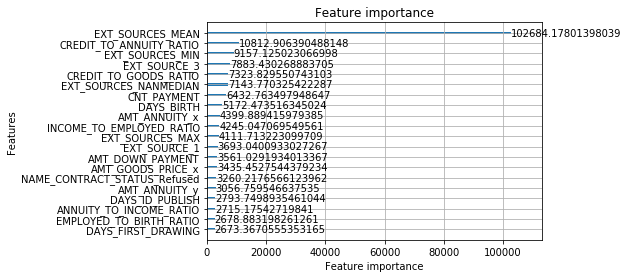

In [57]:
#Plot Variable Importances
lgb.plot_importance(lgbm, max_num_features=20, importance_type='split')
lgb.plot_importance(lgbm, max_num_features=20, importance_type='gain')

In [58]:
predictions_lgbm_prob = lgbm.predict(test)

In [59]:
lgbm_submission = pd.read_csv('sample_submission.csv')

In [60]:
lgbm_submission.TARGET = predictions_lgbm_prob

In [61]:
lgbm_submission.to_csv('lgbm_submission.csv', index=False) #score : 0.774029

data columns

In [62]:
column_info = pd.read_csv('HomeCredit_columns_description.csv', encoding = 'unicode_escape')

In [63]:
column_info[column_info['Table'] == 'previous_application.csv'][:3]

,Unnamed: 0,Table,Row,Description,Special
173,176,previous_application.csv,SK_ID_PREV,ID of previous credit in Home credit related t...,hashed
174,177,previous_application.csv,SK_ID_CURR,ID of loan in our sample,hashed
175,178,previous_application.csv,NAME_CONTRACT_TYPE,"Contract product type (Cash loan, consumer loa...",NaN
